In [1]:
import numpy as np
import pandas as pd
import sympy as sym
import math
from sympy.printing.theanocode import theano_function
import matplotlib.pyplot as plt
import utils
import _MEWtools as mt
import cycloidData

In [2]:
interior = utils.import_interior('interior1')

TOLERANCE = 1

cycloids = cycloidData.loadAllCycloids()
highResCycloids = cycloidData.loadAllCycloids(pointsPerCurve=10000)

In [3]:
import utils

overrides = {
    'obliquity': 0,
    'obliquityPhase': 0,
    'obliquityPhaseRate': 0,
    'spinRate': 0,
    'nonSynchronusRotationRate': 0,
    'librationAmplitude': 0,
    'librationPhase': 0,
    'librationFrequency': 0
}

sample_sat = utils.import_structure('Sample', overrides)

In [4]:
r, θ, φ, t = sym.symbols('r θ φ t', real = True)
stress = theano_function([t, φ, θ], (sample_sat.PC1, sample_sat.PC2, sample_sat.PCΨ, sample_sat.PCΨ2), 
                    dims={t: 1, φ: 1, θ:1}, 
                    dtypes={t: 'float64', φ: 'float64', θ:'float64'})

fnp = sym.lambdify([t, φ, θ], sample_sat.PC1, 'numpy')

In [ ]:
# f(.2, 1, 1)

In [5]:
SIZE = 18000000

europa_orbit_seconds = 85 * 3600

time = np.random.default_rng().uniform(0, europa_orbit_seconds, SIZE)
colat = np.random.default_rng().uniform(0, np.pi, SIZE)
lon = np.random.default_rng().uniform(0, 2*np.pi, SIZE)

In [ ]:
%timeit f(time, colat, lon)
%timeit fnp(time, colat, lon)

In [ ]:
results = stress(time, colat, lon)

In [ ]:
results[3].shape

In [ ]:
results = stress(time, colat, lon)
maxStress = np.maximum(results[0], results[1])
key = maxStress == results[0]
theta = np.select([key, np.invert(key)], [results[2], results[3]])

output = np.column_stack((maxStress, theta, colat, lon, time))
output

In [ ]:
df = pd.DataFrame(output, columns=['stress', 'heading', 'lat', 'lon', 'time'])

In [75]:
def getMewStressField(times, colats, lons):
    results = stress(times, colats, lons)
    maxStress = np.maximum(results[0], results[1])
    key = maxStress == results[0]
    theta = np.select([key, np.invert(key)], [results[2], results[3]])

    return np.column_stack((maxStress, theta, colats, lons, times))

In [76]:
def getMewFieldForCurve(curve, timeSteps):
    EUROPA_ORBIT_SECONDS = 85 * 3600
    
    points = curve[['lon', 'lat']].copy()
    points['lon'] = np.radians(360-points['lon'])
    points['lat'] = np.radians(90-points['lat'])
    
    times = np.arange(0, EUROPA_ORBIT_SECONDS, EUROPA_ORBIT_SECONDS/timeSteps)
    
    coord_index = np.array(points.index)
    combos = np.array(np.meshgrid(coord_index, times)).T.reshape(-1, 2)
    
    lons = np.array(points.iloc[combos[:, 0:1].flatten()]['lon'])
    lats = np.array(points.iloc[combos[:, 0:1].flatten()]['lat'])
    fullTimes = combos[:, 1:2].flatten()
    
    output = getMewStressField(fullTimes, lats, lons)
    df = pd.DataFrame(output, columns=['stress', 'heading', 'lat', 'lon', 'time'])
    df['lat'] = np.round(np.degrees(df['lat']), 4)
    df['lon'] = np.round(np.degrees(df['lon']), 4)
    
    return df

In [52]:
curve = highResCycloids['delphi'].curve.copy()
curve['lon'] = np.radians(360-curve['lon'])
curve['lat'] = np.radians(90-curve['lat'])

coord_index = np.array(curve.index)
combos = np.array(np.meshgrid(coord_index, times)).T.reshape(-1, 2)


In [61]:
lons = np.array(curve.iloc[combos[:, 0:1].flatten()]['lon'])
lats = np.array(curve.iloc[combos[:, 0:1].flatten()]['lat'])
fullTimes = combos[:, 1:2].flatten()

output = getMewStressField(fullTimes, lats, lons)
df = pd.DataFrame(output, columns=['stress', 'heading', 'lat', 'lon', 'time'])
df['lat'] = np.round(np.degrees(df['lat']), 4)
df['lon'] = np.round(np.degrees(df['lon']), 4)

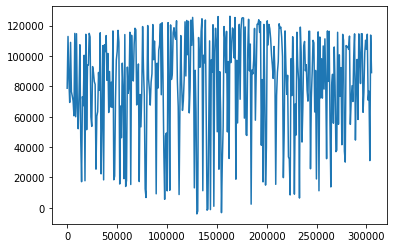

In [59]:
filtered = df.loc[(df['lat'] == 158.2) & (df['lon'] == 130.07)]
# filtered = df.loc[(df['time'] == 100)]
plt.plot(filtered['time'], filtered['stress'])

In [33]:
%timeit output = getMewStressField(fullTimes, lats, lons)

3.95 s ± 28.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [51]:
coord_index = np.array(curve.index)
combos = np.array(np.meshgrid(coord_index, times)).T.reshape(-1, 2)

np.array(curve.iloc[combos[:, 0:1].flatten()][['lon', 'lat']])
# combos[:, 0:1]

array([[2.27014976, 2.76111088],
       [2.27014976, 2.76111088],
       [2.27014976, 2.76111088],
       ...,
       [3.68908159, 2.67874258],
       [3.68908159, 2.67874258],
       [3.68908159, 2.67874258]])

In [63]:
highResCycloids['sidon'].curve.shape

(130000, 7)

In [78]:
getMewFieldForCurve(highResCycloids['delphi'].curve, 360)

,stress,heading,lat,lon,time
0,98439.137346,-0.712704,158.2000,130.0700,0.0
1,99414.372105,-0.716718,158.2000,130.0700,850.0
2,100364.592307,-0.720601,158.2000,130.0700,1700.0
3,101289.268397,-0.724361,158.2000,130.0700,2550.0
4,102187.897031,-0.728006,158.2000,130.0700,3400.0
...,...,...,...,...,...
17999995,35191.049923,-0.512191,153.4806,211.3688,301750.0
17999996,35211.895154,-0.521223,153.4806,211.3688,302600.0
17999997,35237.146213,-0.530162,153.4806,211.3688,303450.0
17999998,35266.560640,-0.539008,153.4806,211.3688,304300.0
